In [10]:
# -*- coding: utf-8 -*-
"""

"""


import torch
import numpy as np 
import os
import sys
import ot
import matplotlib.pyplot as plt
import time


In [11]:
parent_path='/home/baly/projects/Sliced_opt/code'
sys.path.append(parent_path)
os.chdir(parent_path)
from sopt.library import *
from sopt.lib_ot import *   
from sopt.opt import pot  

In [12]:
#@nb.njit(nb.types.Tuple((nb.float64,nb.float64[:],nb.float64[:],nb.int64[:],nb.int64[:]))(nb.float64[:,:],nb.float64))

@nb.njit(nb.types.Tuple((nb.float64,nb.float64[:],nb.float64[:],nb.int64[:],nb.int64[:]))(nb.float64[:,:],nb.float64))
def solve_opt3(c,lam): #,verbose=False):
    M,N=c.shape
    
    phi=np.full(shape=M,fill_value=-np.inf)
    psi=np.full(shape=N,fill_value=lam)
    # to which cols/rows are rows/cols currently assigned? -1: unassigned
    piRow=np.full(M,-1,dtype=np.int64)
    piCol=np.full(N,-1,dtype=np.int64)
    # a bit shifted from notes. K is index of the row that we are currently processing
    K=0
    # Dijkstra distance array, will be used and initialized on demand in case 3 subroutine
    dist=np.full(M,np.inf)

    jLast=-1
    while K<M:
#        if verbose: print(f"K={K}")
        if jLast==-1:
            j=np.argmin(c[K,:]-psi)
        else:
            j=jLast+np.argmin(c[K,jLast:]-psi[jLast:])
        val=c[K,j]-psi[j]
        if val>=lam:
            #if verbose: print("case 1")
            phi[K]=lam
            K+=1
        elif piCol[j]==-1:
            #if verbose: print("case 2")
            piCol[j]=K
            piRow[K]=j
            phi[K]=val
            K+=1
            jLast=j
        else:
            #if verbose: print("case 3")
            phi[K]=val
            #assert piCol[j]==K-1
            # Dijkstra distance vector and currently explored radius
            dist[K]=0.
            dist[K-1]=0.
            v=0

            # iMin and jMin indicate lower end of range of contiguous rows and cols
            # that are currently examined in subroutine;
            # upper end is always K and j
            iMin=K-1
            jMin=j
            # threshold until an entry of phi hits lam
            if phi[K]>phi[K-1]:
                lamDiff=lam-phi[K]
                lamInd=K
            else:
                lamDiff=lam-phi[K-1]
                lamInd=K-1
            resolved=False
            while not resolved:
                # threshold until constr iMin,jMin-1 becomes active
                if jMin>0:
                    lowEndDiff=c[iMin,jMin-1]-phi[iMin]-psi[jMin-1]
                    # catch: empty rows in between that could numerically be skipped
                    if iMin>0:
                        if piRow[iMin-1]==-1:
                            lowEndDiff=np.infty
                else:
                    lowEndDiff=np.infty
                # threshold for upper end
                if j<N-1:
                    hiEndDiff=c[K,j+1]-phi[K]-psi[j+1]-v
                else:
                    hiEndDiff=np.infty
                if hiEndDiff<=min(lowEndDiff,lamDiff):
                 #  if verbose: print("case 3.1")
                    v+=hiEndDiff
                    domain1=arange(iMin,K)
                    phi[domain1]+=v-dist[domain1]
                    psi[piRow[domain1]]-=v-dist[domain1]
                    i=K-1
                    
                    # for i in range(iMin,K):
                    #     phi[i]+=v-dist[i]
                    #     psi[piRow[i]]-=v-dist[i]
                    phi[K]+=v
                    piRow[K]=j+1
                    piCol[j+1]=K
                    jLast=j+1
                    resolved=True
                elif lowEndDiff<=min(hiEndDiff,lamDiff):
                    if piCol[jMin-1]==-1:
                    #    if verbose: print("case 3.2a")
                        v+=lowEndDiff
                        domain1=arange(iMin,K)
                        phi[domain1]+=v-dist[domain1]
                        psi[piRow[domain1]]-=v-dist[domain1]
                        i=K-1
                        # for i in range(iMin,K):
                        #     phi[i]+=v-dist[i]
                        #     psi[piRow[i]]-=v-dist[i]
                        phi[K]+=v
                        # "flip" assignment along whole chain
                        jPrime=jMin
                        piCol[jMin-1]=iMin
                        piRow[iMin]-=1
                        domain2=arange(iMin+1,K)
                        piCol[domain2-(iMin+1)+jPrime]+=1
                        piRow[domain2]-=1
                        jPrime=K-(iMin+1)+jPrime
                        i=K-1
                        # for i in range(iMin+1,K):
                        #     piCol[jPrime]+=1
                        #     piRow[i]-=1
                        #     jPrime+=1
                        piRow[K]=jPrime
                        piCol[jPrime]+=1
                        resolved=True
                    else:
                      #  if verbose: print("case 3.2b")
                      #  assert piCol[jMin-1]==iMin-1
                        v+=lowEndDiff
                        dist[iMin-1]=v
                        # adjust distance to threshold
                        lamDiff-=lowEndDiff
                        iMin-=1
                        jMin-=1
                        if lam-phi[iMin]<lamDiff:
                            lamDiff=lam-phi[iMin]
                            lamInd=iMin

                else:
                 #   if verbose: print(f"case 3.3, lamInd={lamInd}")
                    v+=lamDiff
                    for i in range(iMin,K):
                        phi[i]+=v-dist[i]
                        psi[piRow[i]]-=v-dist[i]
                    phi[K]+=v
                    # "flip" assignment from lambda touching row onwards
                    if lamInd<K:
                        jPrime=piRow[lamInd]
                        piRow[lamInd]=-1
                        domain1=arange(lamInd+1,K)
                        piRow[domain1]-=1
                        piCol[domain1-(lamInd+1)+jPrime]+=1
                        jPrime=K-(lamInd+1)+jPrime
                        i=K-1
                        # for i in range(lamInd+1,K):
                        #     piCol[jPrime]+=1
                        #     piRow[i]-=1
                        #     jPrime+=1
                        piRow[K]=jPrime
                        piCol[jPrime]+=1
                    resolved=True
            #assert np.min(c-phi.reshape((M,1))-psi.reshape((1,N)))>=-1E-15
            K+=1
    objective=np.sum(phi)+np.sum(psi)
    print('done')
    return objective,phi,psi,piRow,piCol


10
done
done
done
done
done
20
done
done
done
done
done
30
done
done
done
done
done
40
done
done
done
done
done
50
done
done
done
done
done
60
done
done
done
done
done
70
done
done
done
done
done
80
done
done
done
done
done
90
done
done
done
done
done


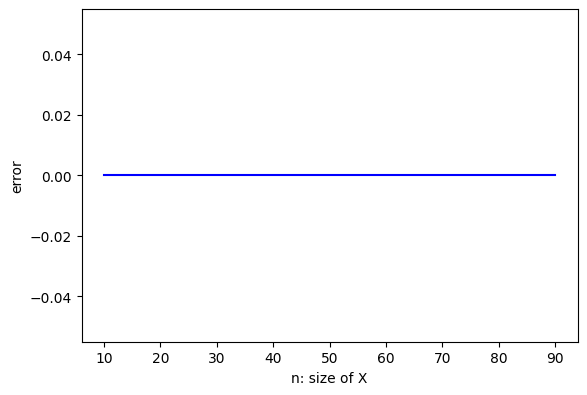

In [13]:

Lambda=np.float32(20.0)

start_n=10
end_n=100
step=10
n_list=np.array(range(start_n,end_n,step))
N=n_list.shape[0]
k=5

cost_new_list=np.zeros((N,k))
cost_lp_list=np.zeros((N,k))
for i in range (N):
    n=n_list[i]
    print(n)
    m=n+0
    for j in range(k):
        X=np.random.uniform(-20,20,n).astype(np.float32)
        # np.random.seed(m)
        Y=np.random.uniform(-40,40,m).astype(np.float32)
        X.sort()
        Y.sort()
        mu=np.ones(n)
        nu=np.ones(m)    
        M=cost_matrix(X,Y)
        
    #   cost_v2-=Lambda*np.sum(n-np.sum(L_v2>=0))
        numItermax=max(300000*n/1000,300000)
        cost_lp,L_lp=opt_lp(X,Y,Lambda,numItermax=numItermax)
        mass_lp=np.sum(L_lp)
        cost_lp=np.sum(M*L_lp)+Lambda*(n-mass_lp)
        cost_lp_list[i,j]=cost_lp
        
        M=cost_matrix(X,Y)
        obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda)
        L=piRow.copy()
        L_new=array_to_matrix(L,m)
        mass_new=np.sum(L_new)
        cost_new=np.sum(M*L_new)+Lambda*(n-mass_new)

        cost_new_list[i,j]=cost_new
        if abs(cost_new-cost_lp)>1e-4:
            print('error')
            X0=X.copy()
            Y0=Y.copy()
#                break
#     else:
#         continue 
# else:
#     continue



error_new_lp=abs(cost_new_list-cost_lp_list)/n_list.reshape(N,1)
error_new_lp_mean=error_new_lp.mean(1)
error_new_lp_std=error_new_lp.std(1)
# error_v2a_lp=abs(cost_v2a_list-cost_lp_list)/n_list.reshape(N,1)
# error_v2a_lp_mean=error_v2a_lp.mean(1)
# error_v2a_lp_std=error_v2a_lp.std(1)*(k-1)/k

#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.plot(n_list,cost_v2_list/n_list,linewidth=3,label='ours')
#     plt.plot(n_list,cost_v2_a_list/n_list,label='ours-apro')
#     plt.plot(n_list,cost_pr_list/n_list,linewidth=2,label='Lp (primal): python OT')
#     plt.plot(n_list,cost_lp_list/n_list,label='Lp: python OT')
#     #lt.plot(range(start_n,end_n,step),cost_lp_list,label='Sinkhorn: python OT')
#     plt.xlabel("n: size of X")
#     plt.ylabel("normalized OPT distance")
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                       box.width, box.height * 0.9])
#     plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),
#               fancybox=True, shadow=True, ncol=3)
# #    plt.savefig("myImage.png", format="png", dpi=resolution_value)
#     plt.savefig('experiment/test/results/accuracy'+str(Lambda)+'.png',format="png",dpi=2000,bbox_inches='tight')
#     plt.show()


fig = plt.figure(1)
ax = plt.subplot(111)
plt.plot(n_list,error_new_lp_mean,'-',c='blue',label='error |new-lp|')
plt.fill_between(n_list,error_new_lp_mean-1*error_new_lp_std,error_new_lp_mean+1*error_new_lp_std,alpha=0.3)

#    plt.plot(n_list,error_v2a_lp_mean,'-',label='error |outs_a-lp|',c='C1')
#    plt.fill_between(n_list,error_v2a_lp_mean-1*error_v2a_lp_std,error_v2a_lp_mean+1*error_v2a_lp_std,alpha=0.3)

plt.xlabel("n: size of X")
plt.ylabel("error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                  box.width, box.height * 0.9])
#    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),              fancybox=True, shadow=True, ncol=3)
#plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
plt.show()

# cost_list={}
# cost_list['cost_v2_list']=cost_v2_list
# cost_list['cost_v2a_list']=cost_v2a_list 
# cost_list['cost_pr_list']=cost_pr_list
# cost_list['cost_lp_list']=cost_lp_list
# cost_list['cost_new_list']=cost_new_list
# torch.save(cost_list,'experiment/test/results/accuracy_list'+str(Lambda)+'.pt')


# for Lambda in Lambda_list:
#     start_n=50
#     end_n=1000
#     step=5
#     cost_list=torch.load('experiment/test/results/accuracy_list'+str(Lambda)+'.pt')
#     cost_v2_list=cost_list['cost_v2_list']
#     cost_v2_a_list=cost_list['cost_v2_a_list'] 
#     cost_pr_list=cost_list['cost_pr_list']
#     cost_lp_list=cost_list['cost_lp_list']
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.semilogy(range(start_n,end_n,step),cost_v2_list-cost_lp_list,'-',label='error |outs-lp|')
#     plt.semilogy(range(start_n,end_n,step),cost_v2_a_list-cost_lp_list,label='error |ours_a-lp|')
#     plt.xlabel("n: size of X")
#     plt.ylabel("error")
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                      box.width, box.height * 0.9])
#     plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
#               fancybox=True, shadow=True, ncol=3)
#     plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=2000,bbox_inches='tight')
#     plt.show()



# plt.plot(range(start_n,end_n,10),time2_list,label='out OPT')
# plt.plot(range(start_n,end_n,10),time3_list,label='Partial OT')
# plt.plot(range(start_n,end_n,10),time4_list,label='Sinkhorn')
# plt.xlabel("n: size of X")
# plt.ylabel("runing time")
# plt.legend(loc='best')
# plt.show()

In [133]:
n

90

In [23]:
m

60

In [24]:
M.shape

(50, 50)

50
60
70


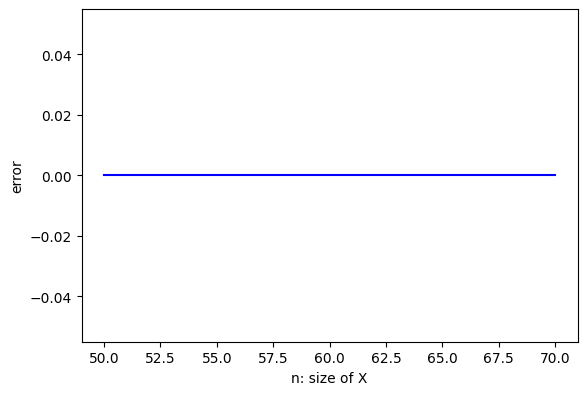

50
60
70


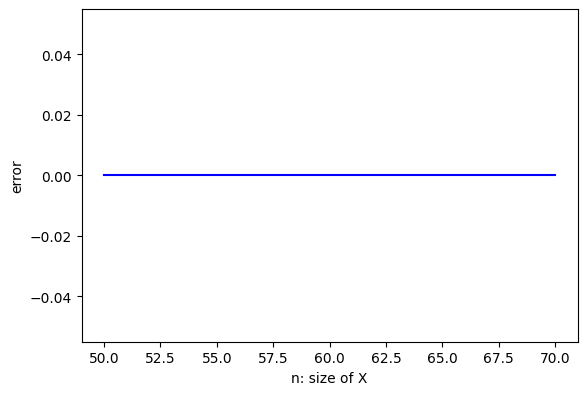

50
60
70


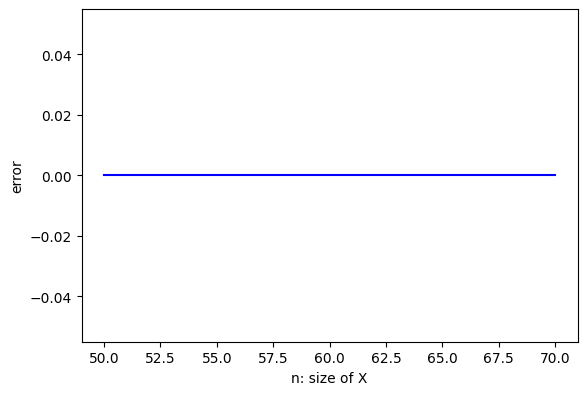

In [12]:

Lambda_list=np.array([10.0,50.0,100.0])

start_n=50
end_n=80
step=10
n_list=np.array(range(start_n,end_n,step))
N=n_list.shape[0]
k=5

for Lambda in Lambda_list:
    cost_v2_list=np.zeros((N,k))
    cost_v2a_list=np.zeros((N,k))
    cost_lp_list=np.zeros((N,k))
    cost_pr_list=np.zeros((N,k))
    cost_new_list=np.zeros((N,k))
    for i in range (N):
        n=n_list[i]
        print(n)
        m=n+0
        for j in range(k):
            X=np.random.uniform(-20,20,n)
            # np.random.seed(m)
            Y=np.random.uniform(-40,40,m)
            X.sort()
            Y.sort()
            mu=np.ones(n)
            nu=np.ones(m)    
            M=cost_matrix(X,Y)


        #   cost_v2-=Lambda*np.sum(n-np.sum(L_v2>=0))
            numItermax=max(300000*n/1000,300000)
            cost_lp,L_lp=opt_lp(X,Y,Lambda,numItermax=numItermax)
            mass_lp=np.sum(L_lp)
            cost_lp=np.sum(M*L_lp)+Lambda*(n-mass_lp)
            cost_lp_list[i,j]=cost_lp
    
        #   L3=ot.partial.partial_wasserstein
            # L_pr=ot.partial.partial_wasserstein(mu,nu,M,mass_lp,3500)
            # cost_pr=np.sum(M*L_pr)+Lambda*(n-mass_lp)
            # cost_pr_list[i,j]=cost_pr
            
            
            M=cost_matrix(X,Y)
            obj,phi,psi,piRow,piCol=solve_opt(M,Lambda)
            L_new=getPiFromRow(n,m,piRow)
            mass_new=np.sum(L_new)
            cost_new=np.sum(M*L_new)+Lambda*(n-mass_new)
            
            cost_new_list[i,j]=cost_new
            if abs(cost_new-cost_lp)>1e-4:
                print('error')
                X0=X.copy()
                Y0=Y.copy()
#                break
    #     else:
    #         continue 
    # else:
    #     continue
    

        
    error_v2_lp=abs(cost_new_list-cost_lp_list)/n_list.reshape(N,1)
    error_v2_lp_mean=error_v2_lp.mean(1)
    error_v2_lp_std=error_v2_lp.std(1)
    # error_v2a_lp=abs(cost_v2a_list-cost_lp_list)/n_list.reshape(N,1)
    # error_v2a_lp_mean=error_v2a_lp.mean(1)
    # error_v2a_lp_std=error_v2a_lp.std(1)*(k-1)/k
    
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.plot(n_list,cost_v2_list/n_list,linewidth=3,label='ours')
#     plt.plot(n_list,cost_v2_a_list/n_list,label='ours-apro')
#     plt.plot(n_list,cost_pr_list/n_list,linewidth=2,label='Lp (primal): python OT')
#     plt.plot(n_list,cost_lp_list/n_list,label='Lp: python OT')
#     #lt.plot(range(start_n,end_n,step),cost_lp_list,label='Sinkhorn: python OT')
#     plt.xlabel("n: size of X")
#     plt.ylabel("normalized OPT distance")
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                       box.width, box.height * 0.9])
#     plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),
#               fancybox=True, shadow=True, ncol=3)
# #    plt.savefig("myImage.png", format="png", dpi=resolution_value)
#     plt.savefig('experiment/test/results/accuracy'+str(Lambda)+'.png',format="png",dpi=2000,bbox_inches='tight')
#     plt.show()
    
    
    fig = plt.figure(1)
    ax = plt.subplot(111)
    plt.plot(n_list,error_v2_lp_mean,'-',c='blue',label='error |new-lp|')
    plt.fill_between(n_list,error_v2_lp_mean-1*error_v2_lp_std,error_v2_lp_mean+1*error_v2_lp_std,alpha=0.3)
    
#    plt.plot(n_list,error_v2a_lp_mean,'-',label='error |outs_a-lp|',c='C1')
#    plt.fill_between(n_list,error_v2a_lp_mean-1*error_v2a_lp_std,error_v2a_lp_mean+1*error_v2a_lp_std,alpha=0.3)
    
    plt.xlabel("n: size of X")
    plt.ylabel("error")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                      box.width, box.height * 0.9])
#    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),              fancybox=True, shadow=True, ncol=3)
    plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
    plt.show()
    
    cost_list={}
    cost_list['cost_v2_list']=cost_v2_list
    cost_list['cost_v2a_list']=cost_v2a_list 
    cost_list['cost_pr_list']=cost_pr_list
    cost_list['cost_lp_list']=cost_lp_list
    cost_list['cost_new_list']=cost_new_list
    torch.save(cost_list,'experiment/test/results/accuracy_list'+str(Lambda)+'.pt')


# for Lambda in Lambda_list:
#     start_n=50
#     end_n=1000
#     step=5
#     cost_list=torch.load('experiment/test/results/accuracy_list'+str(Lambda)+'.pt')
#     cost_v2_list=cost_list['cost_v2_list']
#     cost_v2_a_list=cost_list['cost_v2_a_list'] 
#     cost_pr_list=cost_list['cost_pr_list']
#     cost_lp_list=cost_list['cost_lp_list']
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.semilogy(range(start_n,end_n,step),cost_v2_list-cost_lp_list,'-',label='error |outs-lp|')
#     plt.semilogy(range(start_n,end_n,step),cost_v2_a_list-cost_lp_list,label='error |ours_a-lp|')
#     plt.xlabel("n: size of X")
#     plt.ylabel("error")
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                      box.width, box.height * 0.9])
#     plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
#               fancybox=True, shadow=True, ncol=3)
#     plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=2000,bbox_inches='tight')
#     plt.show()
    


# plt.plot(range(start_n,end_n,10),time2_list,label='out OPT')
# plt.plot(range(start_n,end_n,10),time3_list,label='Partial OT')
# plt.plot(range(start_n,end_n,10),time4_list,label='Sinkhorn')
# plt.xlabel("n: size of X")
# plt.ylabel("runing time")
# plt.legend(loc='best')
# plt.show()